In [1]:
# test file implementation of regularization of damage (d) using lipschitz constraints
import numpy as np
import scipy
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint


In [2]:
# A fabricated damage field
dn = [0., 0.0473944, 0.0898275, 0.127299, 0.15981, 0.187359, 0.209947, 0.227574,  0.24024,  0.247944,0.250687, 0.248469, 0.24129,  0.229149, 0.212047, 0.189984, 0.16296, 0.130974, 0.0940275, 0.0521194, 0.00525]


L = 1.05*10**-3     # Bar length
x0 = 0              # Left extremitiy x coordinate / 0-initial
xf = L              # Rigth extremitiy x coordinate / f-final
n_el = 21           # Number of elements
hun = L/n_el        # Element length

# Points coordinates for a uniform mesh
node_coord = np.linspace(x0, xf, n_el+1)
# Coordenates of integration points
x = [hun*i + hun*0.5 for i in range(n_el)]


# A critical stress field to fabricate concentrated damage at L/2
stress_critical = 300.0*10**4
sigmac = [(abs(node_coord[i]-L/2)**0.5)/((L/2)**0.5 /
                                         (stress_critical*3)) + stress_critical for i in range(n_el)]

n_element_reg = 14
l = n_element_reg * hun     # Regularization length

w = 2.                      # Weight quadrature

E = 275.0*10**9     # Young's module (Pa)
Gc = 100.0          # Fracture energy
strain = 5*10**-5   # Assuming constant strain
 
Yc = [sigmac[el]**2 / (2.*E) for el in range(n_el)] 
lamb = [2. * Yc[el] * l / Gc for el in range(n_el)]  
def h(lamb,d): return (2*d - d**2) / (1 - d + lamb * d**2) **2

def func(d): return w*sum([
            (0.5*(1. - d[el])** 2 * 
            E*strain**2 + 
            Yc[el] * 
            h(lamb[el], d[el])) * 
            hun/2.
            for el in range(n_el)
    ])


In [3]:
# Optimization without constraints 

ddash_opt = minimize(
    fun=func,
    x0=dn,
    method='SLSQP',
    bounds=zip(dn, [1.]*n_el),
    tol=1e-9
)

ddash = ddash_opt.x
# print("Minimization output: ", "\n", ddash_opt)

In [4]:
# Upper projection
upper = [-minimize(
    lambda y: -ddash[np.searchsorted(node_coord, y[0])-1] + abs(x[el]-y[0])/l,
    x0=0.5*L,
    method='SLSQP',
    bounds=[(x0, xf)],
    tol=1e-9
).fun
    for el in range(n_el)
]

In [5]:
# Lower projection
lower = [minimize(
    lambda y: ddash[np.searchsorted(node_coord, y[0])-1] + abs(x[el]-y[0])/l,
    x0=0.5*L,
    method='SLSQP',
    bounds=[(x0, xf)],
    tol=1e-9
).fun
    for el in range(n_el)
]

In [8]:
# Using LinearConstraint but compute damage everywhere

A_everywhere = scipy.sparse.eye(n_el-1, n_el) - scipy.sparse.eye(n_el-1, n_el, 1)
b_everywhere = hun/l
const_everywhere = LinearConstraint(A_everywhere, -b_everywhere * np.ones(n_el-1), b_everywhere * np.ones(n_el-1))

dlip_everywhere_opt = minimize(
    fun=func,
    x0=dn,
    method='SLSQP',
    bounds=zip(dn, [1.]*n_el),
    tol=1e-9,
    constraints=const_everywhere,
)
dlip_everywhere = dlip_everywhere_opt.x

# print("Minimization output: ", "\n", dlip_everywhere_opt)


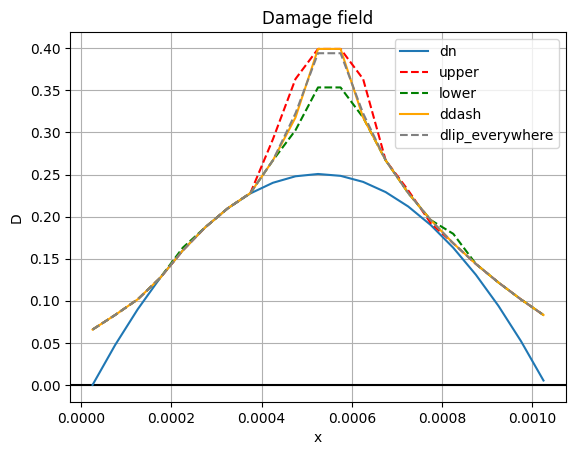

In [7]:
# Plot

def PlotDamage(x, dn, ddash, upper, lower, dlip_everywhere):
    fig, axes = plt.subplots()
    axes.grid(True, which='both')
    axes.axhline(y=0, color='k')

    plt.title(str("Damage field"))
    plt.xlabel(str("x"))
    plt.ylabel(str("D"))
    plt.plot(x, dn, label='dn')
    plt.plot(x, upper, label='upper', color='red', linestyle = 'dashed')
    plt.plot(x, lower, label='lower', color='green', linestyle = 'dashed')
    plt.plot(x, ddash, label='ddash', color='orange')
    plt.plot(x, dlip_everywhere, label='dlip_everywhere', color='gray', linestyle= 'dashed')
    plt.legend()
    plt.show()

PlotDamage(x, dn, ddash, upper, lower, dlip_everywhere)